In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

from tqdm import tqdm

In [2]:
import os

In [3]:
import pyccl as ccl

cosmo = ccl.Cosmology(Omega_c = 0.262, Omega_b = 0.048, h = 0.69, sigma8 = 0.83, n_s = 0.96)

zs=np.linspace(0,1,100)
dNdz = np.ones(zs.shape)
bias = 1*np.ones(len(dNdz))

clustering = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zs,dNdz), bias=(zs,bias))
ell = np.arange(0,6144)
cls_clu = ccl.angular_cl(cosmo, clustering, clustering, ell) #Clustering

In [4]:
kSZMap = hp.read_map("./kSZ_NS_2048_R_2048_P_2560_DV_256.fits")

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [5]:
kSZPowSpec = hp.anafast(kSZMap)

In [7]:
nside = 64
numSets=1050

In [8]:
overdensData = np.zeros((numSets,12*nside**2))
kSZData = np.zeros((numSets,12*nside**2))
velData = np.zeros((numSets,12*nside**2))

In [9]:
kSZFiles = os.listdir('./Data/kSZ')
velFiles = os.listdir('./Data/velocityField')
densFiles = os.listdir('./Data/overdensity')

# for i in range(0,numSets):
#     overdensData[i] = np.load('./Data/overdensity/'+densFiles[i])
#     kSZData[i] = np.load('./Data/kSZ/'+kSZFiles[i])
#     velData[i] = np.load('./Data/velocityField/'+velFiles[i])
for i in range(0,numSets):
    overdensData[i] = hp.reorder(hp.synfast(cls_clu,nside=nside),r2n=True)
    kSZData[i] = hp.reorder(100000*hp.synfast(kSZPowSpec,nside=nside),r2n=True)
    velData[i] = hp.reorder(kSZData[i]/(overdensData[i]+1),r2n=True)

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [10]:
x_raw = np.stack((overdensData,kSZData),axis=2)

In [11]:
x_raw = np.stack((overdensData,kSZData),axis=2)
x_raw = np.reshape(x_raw,(numSets,12*nside**2,2))

x_train, x_test = np.split(x_raw, indices_or_sections=[numSets-50])
y_train, y_test = np.split(velData, indices_or_sections=[numSets-50])

In [33]:
#hp.mollview(overdensData[400])

In [32]:
#hp.mollview(velData[350])

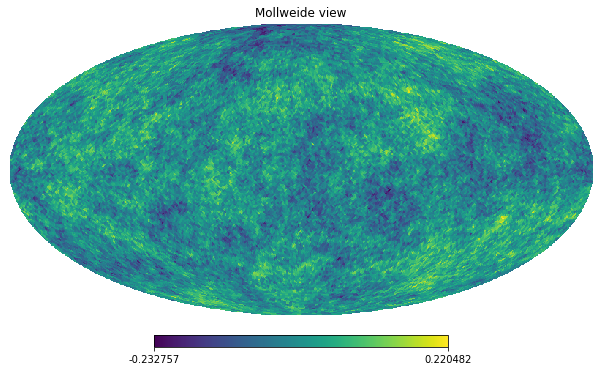

In [68]:
hp.mollview(kSZData[350],nest=True)

In [22]:
K = 5
layers = [hp_layer.HealpyChebyshev(K=K, Fout=8, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=8, activation="elu"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=1, activation="linear")]

In [23]:
n_pix = hp.nside2npix(nside)
indices = np.arange(n_pix)
modelHP = HealpyGCNN(nside=nside, layers=layers,indices=np.arange(0,12*nside**2), n_neighbors=20)
modelHP.build(input_shape=(None, len(indices), 2))
modelHP.summary(110)

Detected a reduction factor of 1.0, the input with nside 64 will be transformed to 64 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_9"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 chebyshev_36 (Chebyshev)                        (None, 49152, 8)                            88               
                                                                                                              
 healpy_pseudo_conv_3 (HealpyPseudoConv)         (None, 12288, 8)                            264              
                                                                                                              
 healpy_pseudo_conv_4 (HealpyPseudoConv)         (None, 3072, 16)                            528              
                       

In [26]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [27]:
modelHP.compile(optimizer=tf.keras.optimizers.Nadam(1e-2),
              loss=tf.keras.losses.Huber(delta=1.0,reduction="auto",name="huber_loss"),
              metrics=[r_square]
)

In [ ]:
history = modelHP.fit(
    x=x_train,
    y=y_train,
    batch_size=5,
    epochs=20,
    validation_data = (x_test,y_test)
)

Epoch 1/20
200/200 [==============================] - 26s 130ms/step - loss: 0.0019 - r_square: -0.0324 - val_loss: 0.0019 - val_r_square: -0.0291
Epoch 2/20
 64/200 [========>.....................] - ETA: 17s - loss: 0.0019 - r_square: -0.0321

In [71]:
original_map = x_train[:350]
reconstructed_map = model(original_map, True).numpy()

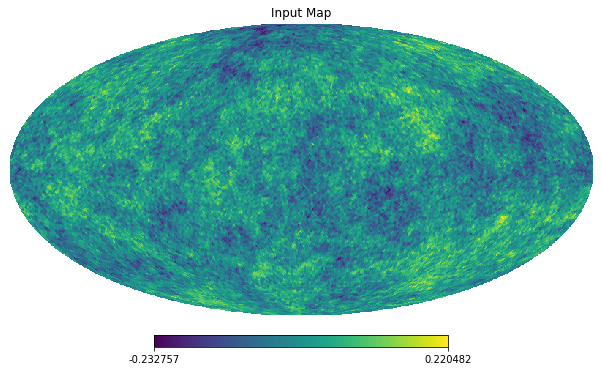

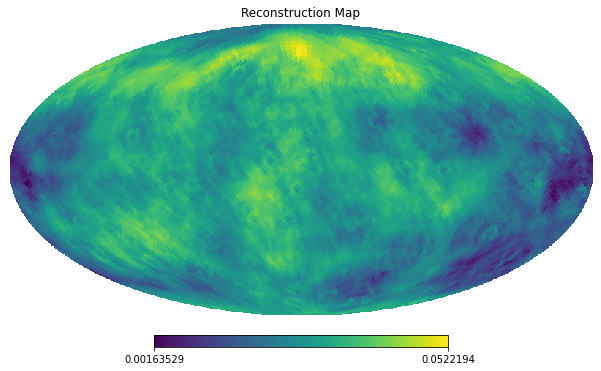

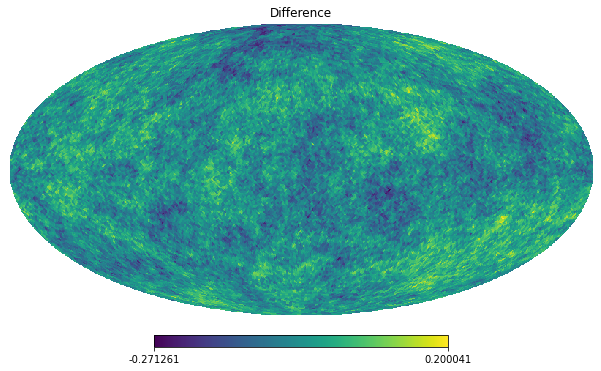

In [73]:
hp.mollview(kSZData[350], nest=True, title="Input Map")
hp.mollview(reconstructed_map[0,:,0], nest=True, title="Reconstruction Map")
hp.mollview(kSZData[350] - reconstructed_map[0,:,0], nest=True, title="Difference")